# Gesture Net Accelerometer Model


In [233]:
#some set up
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import math
import time
from torchsummary import summary
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

### Build GestureNet model for Accelerometer

In [234]:
class GestureAccelNet(nn.Module):
    def __init__(self, num_classes=11):
        super(GestureAccelNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Linear(192,30,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(30,30,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(30,11,bias=True),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(11,self.num_classes,bias=True),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [235]:
model = GestureAccelNet()
print(model)

GestureAccelNet(
  (features): Sequential(
    (0): Linear(in_features=192, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=11, bias=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=11, out_features=11, bias=True)
    (2): LogSoftmax(dim=1)
  )
)


In [236]:
summary(model,input_size=(1,192), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 30]           5,790
              ReLU-2                 [1, 1, 30]               0
            Linear-3                 [1, 1, 30]             930
              ReLU-4                 [1, 1, 30]               0
            Linear-5                 [1, 1, 11]             341
              ReLU-6                 [1, 1, 11]               0
           Dropout-7                 [1, 1, 11]               0
            Linear-8                 [1, 1, 11]             132
        LogSoftmax-9                 [1, 1, 11]               0
Total params: 7,193
Trainable params: 7,193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
-----------------------------------------------

### Load  Dataset

In [237]:
classes = ['0_pinch_index','10_palm_hold','1_palm_tilt','2_finger_slider','3_pinch_pinky','4_slow_swipe','5_fast_swipe','6_push','7_pull','8_finger_rub','9_circle']
x_train = np.zeros(shape=(1,192))

In [238]:
from torch.utils.data import Dataset,DataLoader
class acceldataset(Dataset):
    def __init__(self, data, target):
        dat= np.loadtxt('datasettomp/train/dataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
        self.x_train = torch.from_numpy(dat[:,:192])
        self.y_train = torch.from_numpy(dat[:,[192]])
        self.n_samples = dat.shape[0]
    def __len__(self):
        return self.n_samples
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [239]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=1000)

In [240]:
dataset = acceldataset(data,target)
valdataset = acceldataset(data, target)

In [241]:
train_loader = DataLoader(dataset=dataset, batch_size=200, shuffle=True)
validate_loader = DataLoader(dataset=valdataset, batch_size=1, shuffle=True)

In [242]:
dataiter = iter(train_loader)
data = dataiter.next()
features, label = data
print(features, label)

tensor([[    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,   168.2742,   283.8163,
         -5606.3872]]) tensor([[ 5.],
        [ 9.],
        [ 8.],
        [10.],
        [10.],
        [ 6.],
        [10.],
        [ 3.],
        [ 7.],
        [ 6.],
        [ 2.],
        [ 9.],
        [ 0.],
        [ 2.],
        [ 1.],
        [ 0.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 4.],
        [ 4.],
        [ 6.],
        [10.],
        [ 1.],
        [ 3.],
        [ 2.],
        [ 3.],

### Training Neural Network

In [243]:
train_losses = []
accuracylist = []
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
# Training  Model
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       train_loss = 0
       correct = 0
       # Iterate over data.
       for i,(inputs, labels) in enumerate(train_loader):
           # Forward Pass
           if (i+1) % 5 == 0:
               print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, inputs {inputs.shape}')
           output = model(features)
           #print(torch.argmax(output,axis=1))
           #print(output)
           #print(torch.reshape(labels,(1,20))[0])
           #output1d = torch.argmax(output,axis=1)
           #print(labels.shape)
           labels1d = torch.reshape(input=labels,shape=(1,200))[0]
           loss = criterion(output, labels1d.long())
           optimizer.zero_grad() # clear previous gradients
           loss.backward() # backward pass
           optimizer.step()
           train_loss += loss.item()
           #print(np.argmax(output.detach().numpy(),axis=1))
           #print(labels.detach().numpy())
           correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()
           print('{} Loss: {:.4f}'.format(
               'train', train_loss))
           train_losses.append(loss.item())
       accuracy = 100 * correct / len(dataset)
       accuracylist.append(accuracy)
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

2200 550


In [244]:
validate_losses = []
def validate_model(model, num_epochs=25):
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Evaluate
        # model.eval()
        #Initialize
        correct = 0
        # Iterate over data.
        for features, labels in validate_loader:
            output = model(features.float())
            correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()/len(dataset) *100
        validate_losses.append(correct)
        print('{} Acc: {:.4f}'.format(
            'Validate', correct))

In [245]:
# Define Hyper Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [246]:
train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 19.8059
train Loss: 29.0121
train Loss: 33.4811
train Loss: 36.2417
epoch 1/25, step 5/550, inputs torch.Size([200, 192])
train Loss: 38.9107
train Loss: 41.5227
train Loss: 43.9680
train Loss: 46.4385
train Loss: 48.8564
epoch 1/25, step 10/550, inputs torch.Size([200, 192])
train Loss: 51.3143
train Loss: 53.8430
Epoch 1/24
----------
train Loss: 2.4073
train Loss: 4.8722
train Loss: 7.2548
train Loss: 9.6913
epoch 2/25, step 5/550, inputs torch.Size([200, 192])
train Loss: 12.1315
train Loss: 14.5874
train Loss: 17.0043
train Loss: 19.4493
train Loss: 21.8807
epoch 2/25, step 10/550, inputs torch.Size([200, 192])
train Loss: 24.2939
train Loss: 26.7235
Epoch 2/24
----------
train Loss: 2.4180
train Loss: 4.8227
train Loss: 7.2321
train Loss: 9.6602
epoch 3/25, step 5/550, inputs torch.Size([200, 192])
train Loss: 12.0409
train Loss: 14.4537
train Loss: 16.8740
train Loss: 19.2885
train Loss: 21.7030
epoch 3/25, step 10/550, inputs torch.Size([200, 1

In [247]:
validate_model(model,num_epochs=25)

Epoch 0/24
----------
Validate Acc: 3.3182
Epoch 1/24
----------
Validate Acc: 4.0000
Epoch 2/24
----------
Validate Acc: 3.6364
Epoch 3/24
----------
Validate Acc: 4.0455
Epoch 4/24
----------
Validate Acc: 3.5455
Epoch 5/24
----------
Validate Acc: 3.7727
Epoch 6/24
----------
Validate Acc: 3.1364
Epoch 7/24
----------
Validate Acc: 3.7273
Epoch 8/24
----------
Validate Acc: 3.7727
Epoch 9/24
----------
Validate Acc: 3.5000
Epoch 10/24
----------
Validate Acc: 3.0455
Epoch 11/24
----------
Validate Acc: 3.5455
Epoch 12/24
----------
Validate Acc: 3.9545
Epoch 13/24
----------
Validate Acc: 3.8636
Epoch 14/24
----------
Validate Acc: 4.3182
Epoch 15/24
----------
Validate Acc: 3.5000
Epoch 16/24
----------
Validate Acc: 3.7727
Epoch 17/24
----------
Validate Acc: 4.0909
Epoch 18/24
----------
Validate Acc: 3.7273
Epoch 19/24
----------
Validate Acc: 3.5909
Epoch 20/24
----------
Validate Acc: 4.0000
Epoch 21/24
----------
Validate Acc: 3.5909
Epoch 22/24
----------
Validate Acc: 2.818

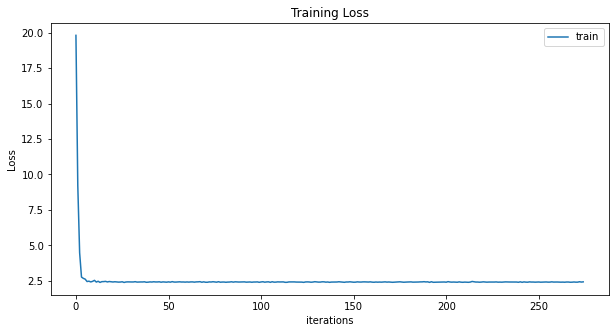

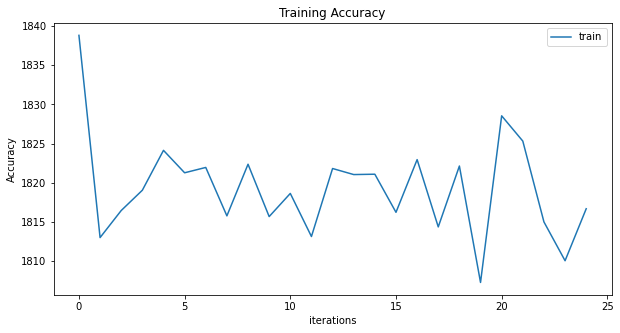

In [248]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(accuracylist,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

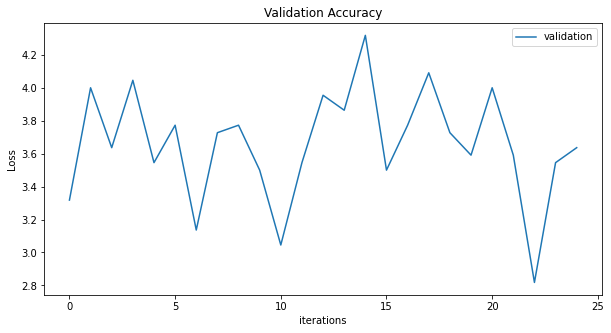

In [249]:
plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(validate_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [82]:
torch.save(model.state_dict(), 'GestureAccelNet2.pth')

### Calculate top-1 accuracy of the pre-trained model

## Test Model in Pytorch if the OpenCL implement is correct
By comprare the result of OpenCL implement and PyTorch implement using a single image as input  
error = ((OpenCL_implement_class_socores - PyTorch_implement_class_socores) ^ 2).sum(element_wise)  
If the OpenCL implement is correct, error should be relativly small.

In [257]:
# load the test image
dataiter = iter(validate_loader)
data = dataiter.next()
features, label = data
print(features, label)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[10.]])


In [258]:
model.cpu()
x_test = features
y_test = model(x_test)
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+str(predicted))

tensor([[-2.3920, -2.5738, -2.5355, -2.3335, -2.6687, -2.3580, -2.2561, -2.2314,
         -2.4919, -2.2607, -2.3749]], grad_fn=<ViewBackward0>)
tensor([7])
the label index prediction of pytorch implement: tensor([7])


In [255]:
x_test=[[0.0,0.0,0.0,120.79496383666992,491.4173698425293,-5083.184838294983,120.79496383666992,491.4173698425293,-5083.184838294983,128.79060745239258,439.01819229125977,-3710.835576057434,128.79060745239258,439.01819229125977,-3710.835576057434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]
x_test = torch.from_numpy(np.array(x_test))
y_test = model(x_test.float())
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+str(predicted))

tensor([[-2.3687, -2.6008, -2.5618, -2.3192, -2.6037, -2.4226, -2.2124, -2.3081,
         -2.5749, -2.2158, -2.3041]], grad_fn=<ViewBackward0>)
tensor([6])
the label index prediction of pytorch implement: tensor([6])


### Load OpenCL implement

#### Step1: OpenCL preparation

In [182]:
# OpenCL setup
import pyopencl as cl
import deviceinfo

In [183]:
# Ask the user to select a platform/device on the CLI
context = cl.create_some_context()

# Print out device info
deviceinfo.output_device_info(context.devices[0])

# Create a command queue
queue = cl.CommandQueue(context)

Device is NVIDIA GeForce GTX 1650 TiGPU from NVIDIA Corporation with a max of 16 compute units


#### Step 2: import parameters from pytorch implement

In [184]:
params = model.state_dict()
for k,v in params.items():
    # print parameter name
    print(k,params[k].numpy().shape)
layer1_weight = params['features.0.weight'].numpy().reshape(-1)
layer1_bias = params['features.0.bias'].numpy()
layer2_weight = params['features.2.weight'].numpy().reshape(-1)
layer2_bias = params['features.2.bias'].numpy()
layer3_weight = params['features.4.weight'].numpy().reshape(-1)
layer3_bias = params['features.4.bias'].numpy()
classifier_weight = params['classifier.1.weight'].numpy().reshape(-1)
classifier_bias = params['classifier.1.bias'].numpy()
print(len(layer1_bias))
print(len(layer2_bias))
print(len(layer3_bias))
print(len(classifier_bias))

features.0.weight (30, 192)
features.0.bias (30,)
features.2.weight (30, 30)
features.2.bias (30,)
features.4.weight (11, 30)
features.4.bias (11,)
classifier.1.weight (11, 11)
classifier.1.bias (11,)
30
30
11
11


In [185]:
print(params['features.0.weight'].numpy()[0].shape)
print(params['features.0.bias'].shape)

(192,)
torch.Size([30])


In [186]:
print(layer1_bias)

[-2.0497430e-02  5.9255693e-02 -5.3185571e-02  7.8292061e-03
 -4.1037392e-02  2.8987655e-02  5.8736976e-02  1.6186383e-02
 -6.9902137e-02  7.1650327e-05  5.3319491e-02  1.4776109e-03
  3.4235779e-02 -5.9565932e-02  1.5850790e-02 -3.8664211e-02
 -5.1582087e-02 -6.2206004e-02  5.2711973e-03 -6.5654643e-02
  1.5027584e-02  3.9559785e-02 -1.7466193e-02 -6.9132619e-02
  2.5216693e-02 -4.1483946e-02  2.4096660e-02 -4.5353282e-02
 -5.2202810e-02  3.2664150e-02]


Create OpenCL memory object

In [187]:
h_sample = x_test.numpy().reshape(-1)
h_result_layer1 = np.empty(1 * len(layer1_bias)).astype(np.float32)
h_result_layer2 = np.empty(1 * len(layer2_bias)).astype(np.float32)
h_result_layer3 = np.empty(1 * len(layer3_bias)).astype(np.float32)
h_result_classifier = np.empty(1 * len(classifier_bias)).astype(np.float32)

# device input buffer
d_sample = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_sample)

# device buffers 
d_layer1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_weight)
d_layer1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_bias)
d_layer2_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_weight)
d_layer2_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_bias)
d_layer3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer3_weight)
d_layer3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer3_bias)
d_classifier_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_weight)
d_classifier_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_bias)

d_result_layer1 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer1.nbytes)
d_result_layer2 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer2.nbytes)
d_result_layer3 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer3.nbytes)
d_result_classifier = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier.nbytes)

#### Step 3: create kernels
Create & build program

In [188]:
kernelSource = open("gesturenet.cl").read()
program = cl.Program(context, kernelSource).build(options="")

Create kernels

In [189]:
conv3x3 = program.conv2d3x3
conv3x3.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, \
                               None, None, None, None])

maxpool = program.maxpool2d
maxpool.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

conv1x1 = program.conv2d1x1
conv1x1.set_scalar_arg_dtypes([np.int32, np.int32, np.int32,\
                               None, None, None, None])

avgpool = program.avgpool2d
avgpool.set_scalar_arg_dtypes([np.int32,np.int32,None, None])

fc = program.fc
fc.set_scalar_arg_dtypes([np.int32,np.int32,None,None,None,None])

Run OpenCL implement  

In [190]:
import time
rtime = time.time()
# First
fc(queue,(len(layer1_bias),),None,len(h_sample),1,d_sample,d_layer1_weight,d_layer1_bias,d_result_layer1)
# Second
fc(queue,(len(layer2_bias),),None,len(layer1_bias),1,d_result_layer1,d_layer2_weight,d_layer2_bias,d_result_layer2)
# Third
fc(queue,(len(layer3_bias),),None,len(layer2_bias),1,d_result_layer2,d_layer3_weight,d_layer3_bias,d_result_layer3)
# classifier
fc(queue,(len(classifier_bias),),None,len(layer3_bias),0,d_result_layer3,d_classifier_weight,d_classifier_bias,d_result_classifier)

queue.finish()
rtime = time.time() - rtime
print("The kernel ran in", rtime, "seconds")

The kernel ran in 0.0029914379119873047 seconds


In [191]:
z = model(x_test.float())
z.detach().numpy().tolist()[0]

[-2.43538236618042,
 -2.3757214546203613,
 -2.568444013595581,
 -2.292815685272217,
 -2.1506237983703613,
 -2.5363268852233887,
 -2.4902496337890625,
 -2.416814088821411,
 -2.243840456008911,
 -2.482288360595703,
 -2.4699766635894775]

In [95]:
#copy result from gpu
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
queue.finish()
label_opencl = np.argmax(h_result_classifier)
print('the label index prediction of OpenCL implement: %d' % label_opencl)
correct_result = y_test.data.numpy().reshape(-1)
print("Predicted Label:", str(np.argmax(y_test.detach().numpy().tolist())))
error = ((correct_result - h_result_classifier) ** 2).sum()
print('OpenCL implement error: ', error)
cl.enqueue_copy(queue, h_result_layer1, d_result_layer1)
print(h_result_layer1.shape)
cl.enqueue_copy(queue, h_result_layer2, d_result_layer2)
print(h_result_layer2.shape)
cl.enqueue_copy(queue, h_result_layer3, d_result_layer3)
print(h_result_layer3.shape)
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
print(h_result_classifier.shape)
print(y_test.detach().numpy().tolist()[0])
print(h_result_classifier)

the label index prediction of OpenCL implement: 4
Predicted Label: 4
OpenCL implement error:  63.182148
(30,)
(30,)
(11,)
(11,)
[-2.43538236618042, -2.3757214546203613, -2.568444013595581, -2.292815685272217, -2.1506237983703613, -2.5363268852233887, -2.4902496337890625, -2.416814088821411, -2.243840456008911, -2.482288360595703, -2.4699766635894775]
[-0.03875305  0.02090775 -0.17181472  0.10381363  0.24600542 -0.13969766
 -0.09362035 -0.02018493  0.15278873 -0.08565913 -0.07334751]


In [98]:
import math
total = 0
for i in range(0,len(h_result_classifier)):
    total += math.exp(h_result_classifier[i])
softlist = []
for j in range(0,len(h_result_classifier)):
    softlist.append(math.log(math.exp(h_result_classifier[j])/total))
print(softlist)
np.argmax(softlist)

[-2.435382260585023, -2.3757214607836734, -2.5684439340772163, -2.2928155834021102, -2.1506237933578025, -2.5363268653096687, -2.4902495617212783, -2.416814139688207, -2.2438404807986747, -2.482288340681983, -2.4699767181815635]


4

In [193]:
# Layer 1
lay1out = []
for i in range(0,len(layer1_bias)):
    tmp = layer1_bias[i]
    for j in range(0, len(h_sample)):
        tmp = tmp + h_sample[j]*layer1_weight[i*len(h_sample)+j]
        #print(j, h_sample[j], layer1_weight[i*len(h_sample)+j], tmp)
    if tmp > 0:
        lay1out.append(tmp)
    else:
        lay1out.append(0)
print(len(lay1out))
print(lay1out)
# Layer 2
lay2out = []
for i in range(0,len(layer2_bias)):
    tmp = layer2_bias[i]
    for j in range(0, len(lay1out)):
        tmp = tmp + lay1out[j]*layer2_weight[i*len(lay1out)+j]
    if tmp > 0:
        lay2out.append(tmp)
    else:
        lay2out.append(0)
print(len(lay2out))
print(lay2out)
# Layer 3
lay3out = []
for i in range(0,len(layer3_bias)):
    tmp = layer3_bias[i]
    for j in range(0, len(lay2out)):
        tmp = tmp + lay2out[j]*layer3_weight[i*len(lay2out)+j]
    if tmp > 0:
        lay3out.append(tmp)
    else:
        lay3out.append(0)
print(len(lay3out))
print(lay3out)
# Layer 4
lay4out = []
for i in range(0,len(classifier_bias)):
    tmp = classifier_bias[i]
    for j in range(0, len(lay3out)):
        tmp = tmp + lay3out[j]*classifier_weight[i*len(lay3out)+j]
    lay4out.append(tmp)
print(len(lay4out))
print(lay4out)
# softmax
import math
total = 0
for i in range(0,len(classifier_bias)):
    total += math.exp(lay4out[i])
softlist = []
for j in range(0,len(classifier_bias)):
    softlist.append(math.log(math.exp(lay4out[j])/total))
print(softlist)
np.argmax(softlist)
print(type(softlist[0]))

30
[0, 2018.0907, 1760.1644, 0, 0, 0, 0, 0, 0, 0, 0, 470.92947, 1153.4535, 0, 0, 0, 0, 0, 0, 0, 72.6766, 0, 1067.8429, 0, 0, 0, 196.82954, 0, 0, 0]
30
[499.7073913961649, 0, 0, 0, 0, 0, 0, 80.00345996022224, 0, 0, 0, 296.9014100395143, 0, 500.3973032264039, 590.3616439029574, 0, 0, 537.6553315445781, 0, 0, 0, 0, 564.6138956546783, 0, 10.332109816372395, 0, 0, 322.15510207414627, 619.0512715987861, 0]
11
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
11
[-0.038753051310777664, 0.020907748490571976, -0.1718147248029709, 0.10381362587213516, 0.24600541591644287, -0.13969765603542328, -0.09362035244703293, -0.02018493041396141, 0.15278872847557068, -0.08565913140773773, -0.07334750890731812]
[-2.435382260585023, -2.3757214607836734, -2.5684439340772163, -2.2928155834021102, -2.1506237933578025, -2.5363268653096687, -2.4902495617212783, -2.416814139688207, -2.2438404807986747, -2.482288340681983, -2.4699767181815635]
<class 'float'>


In [100]:
print(h_result_layer1)

[ 24.962595  65.68494  130.44887    0.       121.920746   0.
   0.       130.16043   83.66256    0.         0.        35.4695
   9.632597   0.         0.         7.300482   0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.       222.11522    0.         0.      ]


In [101]:
print(h_result_layer2)

[30.368639 45.406784 23.563404 24.738811  0.        0.        0.
 14.297806  0.        0.        0.       57.128403  0.        0.
  0.        0.        0.       47.88062   0.        0.        0.
  0.        0.        0.       54.65406   0.        0.        0.
 34.58984   0.      ]


In [102]:
print(h_result_layer3)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [103]:
print(h_result_classifier)

[-0.03875305  0.02090775 -0.17181472  0.10381363  0.24600542 -0.13969766
 -0.09362035 -0.02018493  0.15278873 -0.08565913 -0.07334751]


# Prepare AccNet for Data Fusion

In [104]:
model.cpu()
x_test = features
y_test = model(x_test)
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+str(predicted))

tensor([[-2.4354, -2.3757, -2.5684, -2.2928, -2.1506, -2.5363, -2.4902, -2.4168,
         -2.2438, -2.4823, -2.4700]], grad_fn=<ViewBackward0>)
tensor([4])
the label index prediction of pytorch implement: tensor([4])


In [170]:
print(classes)
classidx=10
dat= np.loadtxt('datasettomp/train/'+classes[classidx]+'/dataset.csv',delimiter=",",dtype=np.float32,skiprows=1)
xf_train = torch.from_numpy(dat[:,:192])
print(xf_train.shape)
resarr=[]
for i in range(0,200):
    xt = xf_train[i].detach().numpy()
    xt = xt[np.newaxis,:]
    xt = torch.from_numpy(xt)
    yf_train=model(xf_train)
    yt = yf_train.detach().numpy().tolist()[0]
    #print(yt)
    yt.append(classidx)
    resarr.append(yt)
    
    #print(yt.shape)

['0_pinch_index', '10_palm_hold', '1_palm_tilt', '2_finger_slider', '3_pinch_pinky', '4_slow_swipe', '5_fast_swipe', '6_push', '7_pull', '8_finger_rub', '9_circle', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class', 'class']
torch.Size([200, 192])


In [171]:
print(len(yt))

12


In [172]:
import csv
names=classes
names.append('class')
#print(files)
with open('fusiondataset/train/'+classes[classidx]+'/adxldataset.csv', 'w',newline='') as f: 
    write = csv.writer(f)
    write.writerow(names)
    for i in range(0,200): 
        write.writerow(yt)

# Export Weights

In [173]:
with open('gesture_acc_weights.h', 'w') as testfile:
    testfile.write('//Layer1 Weights \n')
    testfile.write('float layer1_weight[] = {\n')
    for wx in range(0,len(layer1_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(layer1_weight)-1:
            testfile.write(str(layer1_weight[wx])+'f')
        else:
            testfile.write(str(layer1_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float layer1_bias[] = {\n')
    for rx in range(0,len(layer1_bias)):
        if rx != len(layer1_bias)-1:
            testfile.write(str(layer1_bias[rx])+'f,')
        else:
            testfile.write(str(layer1_bias[rx])+'f')
    testfile.write('};\n')
    
    testfile.write('//Layer2 Weights \n')
    testfile.write('float layer2_weight[] = {\n')
    for wx in range(0,len(layer2_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(layer2_weight)-1:
            testfile.write(str(layer2_weight[wx])+'f')
        else:
            testfile.write(str(layer2_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float layer2_bias[] = {\n')
    for rx in range(0,len(layer2_bias)):
        if rx != len(layer2_bias)-1:
            testfile.write(str(layer2_bias[rx])+'f,')
        else:
            testfile.write(str(layer2_bias[rx])+'f')
    testfile.write('};\n')

    testfile.write('//Layer3 Weights \n')
    testfile.write('float layer3_weight[] = {\n')
    for wx in range(0,len(layer3_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(layer3_weight)-1:
            testfile.write(str(layer3_weight[wx])+'f')
        else:
            testfile.write(str(layer3_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float layer3_bias[] = {\n')
    for rx in range(0,len(layer3_bias)):
        if rx != len(layer3_bias)-1:
            testfile.write(str(layer3_bias[rx])+'f,')
        else:
            testfile.write(str(layer3_bias[rx])+'f')
    testfile.write('};\n')
    
    testfile.write('//Classifier Weights \n')
    testfile.write('float classifier_weight[] = {\n')
    for wx in range(0,len(classifier_weight)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(classifier_weight)-1:
            testfile.write(str(classifier_weight[wx])+'f')
        else:
            testfile.write(str(classifier_weight[wx])+'f,')
    testfile.write('};\n')
    testfile.write('float classifier_bias[] = {\n')
    for rx in range(0,len(classifier_bias)):
        if rx != len(classifier_bias)-1:
            testfile.write(str(classifier_bias[rx])+'f,')
        else:
            testfile.write(str(classifier_bias[rx])+'f')
    testfile.write('};\n')
    

In [ ]:
with open('acctest.h', 'w') as testfile:
    testfile.write('float sample[] = {\n')
    for wx in range(0,len(h_sample)):
        if wx%5==0 and wx!=0:
            testfile.write('\n')
        if wx == len(h_sample)-1:
            testfile.write(str(h_sample[wx])+'f')
        else:
            testfile.write(str(h_sample[wx])+'f,')
    testfile.write('};\n')

In [192]:
with open('acc.txt', 'w') as testfile:
    for wx in range(0,len(h_sample)):
        testfile.write(str(h_sample[wx]))
        if wx < len(h_sample)-1:
            testfile.write('\n')